# Statistical Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from itertools import combinations
import warnings
import scipy.stats as stats
import math
import itertools


In [266]:
# Check python version.
# This code should run for python version >=3.6

print("python", sys.version)

python 3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]


## Get Data

In [267]:
data = pd.read_pickle("processed_data.pkl")

In [268]:
df = data.copy()
df = df.drop('id', axis=1)

## Functions

In [269]:
def check_chi_significance(df, target_column):
    # Loop through all columns to test significance
    p_vals, res = [], []
    for col in df.columns:
        if col == target_column:
            continue  # Skip the target column

        contingency_table = pd.crosstab(df[col], df[target_column])
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        p_vals.append(p)
        if p < 0.05:
            print(f"{col}\n p-value: {p}\n")
        res.append((col, p))
    return p_vals, res

In [ ]:
def check_anova_significance(df, target_column):
    res = []
    
    df['Age'] = df['Age'].astype('category')
    df['NumberofSiblings'] = df['NumberofSiblings'].astype('category')
    df['NumberofParents'] = df['NumberofParents'].astype('category')

    # Loop through all columns to test significance
    for col in df.columns:
        if col == target_column:
            continue  # Skip the target column
        
        # Perform Two-way ANOVA (for numerical data)
        model = ols(f'{target_column} ~ C({col})', data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        p_value = anova_table['PR(>F)'][0]

        res.append((col, p_value))
    return res


In [ ]:
def check_two_way_anova_significance(df, target_column):
    warnings.simplefilter('ignore')
    categorical_vars = df.select_dtypes(include=["object", "category"]).columns
    categorical_vars = [col for col in categorical_vars if col != target_column]

    res = []
    # Loop through all pairs of categorical variables
    for col1, col2 in combinations(categorical_vars, 2):
        formula = f'{target_column} ~ C({col1}) * C({col2})'  # Include interaction term
        model = ols(formula, data=df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA table
        
        # Extract p-values for main effects and interaction
        p_value_interaction = anova_table['PR(>F)'].get(f'C({col1}):C({col2})', None)

        if p_value_interaction is not None and p_value_interaction < 0.05:
            res.append((col1, col2, p_value_interaction))
    return res



In [272]:
def chi_heatmap(d, cat1, cat2):
    df_unique = d.groupby('id').agg({cat1: 'first', cat2: 'first'}).reset_index()
    contingency = pd.crosstab(df_unique[cat1], df_unique[cat2])

    sns.heatmap(contingency, annot=True, fmt="d", cmap="coolwarm")

    plt.title(f"Heatmap of {cat1} vs {cat2}")
    plt.xlabel(cat2)
    plt.ylabel(cat1)
    plt.show()

## ANOVA

In [ ]:
anova_res = check_anova_significance(df, 'Label')
for col, p in anova_res:
    print(f"{col}: {p} - Reject: {p<0.05} \\")

Gender: 0.09597541100424649 - Reject: False \
Age: 0.3767284678902405 - Reject: False \
EducationLevel: 0.32065614029934913 - Reject: False \
EducationGroup: 0.00014373590962577762 - Reject: True \
Student: 0.04614246008098336 - Reject: True \
NumberofSiblings: 0.8107156339389444 - Reject: False \
NumberofParents: 0.21239360382258018 - Reject: False \
FemaleParentEducationGroup: 4.305153010568891e-08 - Reject: True \
FemaleParentEducationLevel: 0.00021696207047103983 - Reject: True \
MaleParentEducationGroup: 5.240043568305408e-23 - Reject: True \
MaleParentEducationLevel: 7.219491358963618e-10 - Reject: True \
FemaleParentInfluence: 0.018925785665334895 - Reject: True \
MaleParentInfluence: 0.038676045346784524 - Reject: True \


## TWO WAY ANOVA

In [275]:
two_anova_res = check_two_way_anova_significance(df, 'Label')
for col1, col2, p in sorted(two_anova_res, key=lambda x: x[2]):
    print(f"{col1} and {col2} : {p}")

EducationGroup and MaleParentEducationGroup : 6.72710160086555e-92
Age and MaleParentEducationGroup : 7.726727208657153e-09
EducationLevel and MaleParentEducationGroup : 3.000354119580485e-08
Student and MaleParentEducationGroup : 1.55243355110573e-07
FemaleParentEducationGroup and MaleParentEducationGroup : 3.658948282742727e-05
EducationGroup and FemaleParentEducationGroup : 0.0001807408508290047
MaleParentEducationGroup and MaleParentInfluence : 0.0014082158682270868
Age and MaleParentEducationLevel : 0.0028103632070865794
Gender and MaleParentEducationLevel : 0.005231590804734449
Gender and FemaleParentEducationGroup : 0.011303103452110871
Gender and EducationGroup : 0.012022677575560758
Age and EducationGroup : 0.01794564430152499
Student and FemaleParentEducationGroup : 0.02108574381681399
NumberofParents and FemaleParentEducationGroup : 0.02520778075961615
MaleParentEducationGroup and MaleParentEducationLevel : 0.027423622520032127
FemaleParentEducationGroup and FemaleParentInfl

## CHI-SQUARED

In [277]:
p_vals, chi_res = check_chi_significance(df, 'Label')

EducationGroup
 p-value: 3.049232163817502e-05

FemaleParentEducationGroup
 p-value: 4.456636626684286e-17

FemaleParentEducationLevel
 p-value: 0.0043865051037044155

MaleParentEducationGroup
 p-value: 1.580666175645784e-20

MaleParentEducationLevel
 p-value: 4.54991826843813e-06

FemaleParentInfluence
 p-value: 0.00027304397725259964

MaleParentInfluence
 p-value: 0.01823740985011757



In [278]:
for col, p in chi_res:
    print(f"{col}: {p} - Reject? {p<0.05} \\")

Gender: 0.1124468096048658 - Reject? False \
Age: 0.49116792203669074 - Reject? False \
EducationLevel: 0.26321399708218995 - Reject? False \
EducationGroup: 3.049232163817502e-05 - Reject? True \
Student: 0.06582492293227579 - Reject? False \
NumberofSiblings: 0.9234467810464595 - Reject? False \
NumberofParents: 0.06287085714419366 - Reject? False \
FemaleParentEducationGroup: 4.456636626684286e-17 - Reject? True \
FemaleParentEducationLevel: 0.0043865051037044155 - Reject? True \
MaleParentEducationGroup: 1.580666175645784e-20 - Reject? True \
MaleParentEducationLevel: 4.54991826843813e-06 - Reject? True \
FemaleParentInfluence: 0.00027304397725259964 - Reject? True \
MaleParentInfluence: 0.01823740985011757 - Reject? True \


## Post-hoc tests

### Functions

In [ ]:
def chi_square_posthoc(df):
    no_of_comparisons = math.factorial(df.transpose().shape[1])/(math.factorial((df.transpose().shape[1])-2)*math.factorial(2))
    print("no_of_comparisons: ", no_of_comparisons)
    # Perform Chi-Square rest of independence
    chi2, p, degs, _ = stats.chi2_contingency(df)
    print(f"Overall Chi-Square: {chi2:.2f}, df: {degs}, p-value: {p}")

    # Post hoc comparisons (pairwise column comparisons)
    col_combos = list(itertools.combinations(df.columns, 2))

    for col1, col2 in col_combos:
            selected_cols = df[[col1, col2]]
            
            # Check if any expected frequency is zero before performing test to prevent error
            try:
                chi2, p, _, expected = stats.chi2_contingency(selected_cols, correction=False)
                if np.any(expected == 0):
                    continue
                
                if p < 0.05/no_of_comparisons:
                    print(f"{col1} vs {col2}: Chi-Square = {chi2:.2f}, p = {p}")
            except ValueError as e:
                continue

In [ ]:
def get_pivot(df, feature):
    # Count occurrences of each ('MaleParentEducationGroup', 'Label') pairs
    df_count = df.groupby([feature, 'Label']).size().reset_index(name='Count')

    # Pivot the dataframe
    df_pivot = df_count.pivot_table(index='Label', columns=feature, values='Count', fill_value=0)

    df_pivot.columns.name = None  # Remove the column index name

    return df_pivot

In [ ]:
def plot_ratio(piv, feature):
    df_ratio = piv.div(piv.sum(axis=0), axis=1).fillna(0)

    df_ratio.transpose().plot(kind='bar', stacked=True, figsize=(8, 6), colormap='tab10')

    plt.xlabel(feature)
    plt.ylabel("Fraction")
    plt.title(f"Proportional Bar Plot of {feature} by Label")
    plt.legend(title="Label", loc="upper right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

### Bonferroni Adjustment
https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests

reject_list, corrected_p_vals = multipletests(p_vals, method='bonferroni')[:2] #bonferroni fdr_bh

print("col\toriginal p-value\tcorrected p-value\treject?")
for n, p_val, corr_p_val, reject in zip(df.columns, p_vals, corrected_p_vals, reject_list):
    print(n, "\t\t", p_val, "\t", corr_p_val, "\t", reject)

col	original p-value	corrected p-value	reject?
Gender 		 0.1124468096048658 	 1.0 	 False
Age 		 0.49116792203669074 	 1.0 	 False
EducationLevel 		 0.26321399708218995 	 1.0 	 False
EducationGroup 		 3.049232163817502e-05 	 0.00039640018129627523 	 True
Student 		 0.06582492293227579 	 0.8557239981195853 	 False
NumberofSiblings 		 0.9234467810464595 	 1.0 	 False
NumberofParents 		 0.06287085714419366 	 0.8173211428745175 	 False
FemaleParentEducationGroup 		 4.456636626684286e-17 	 5.793627614689572e-16 	 True
FemaleParentEducationLevel 		 0.0043865051037044155 	 0.057024566348157404 	 False
MaleParentEducationGroup 		 1.580666175645784e-20 	 2.0548660283395192e-19 	 True
MaleParentEducationLevel 		 4.54991826843813e-06 	 5.914893748969569e-05 	 True
FemaleParentInfluence 		 0.00027304397725259964 	 0.0035495717042837954 	 True
MaleParentInfluence 		 0.01823740985011757 	 0.2370863280515284 	 False


### EducationGroup

In [283]:
edu_group_feature = 'EducationGroup'
edu_group_pivot = get_pivot(df, edu_group_feature)

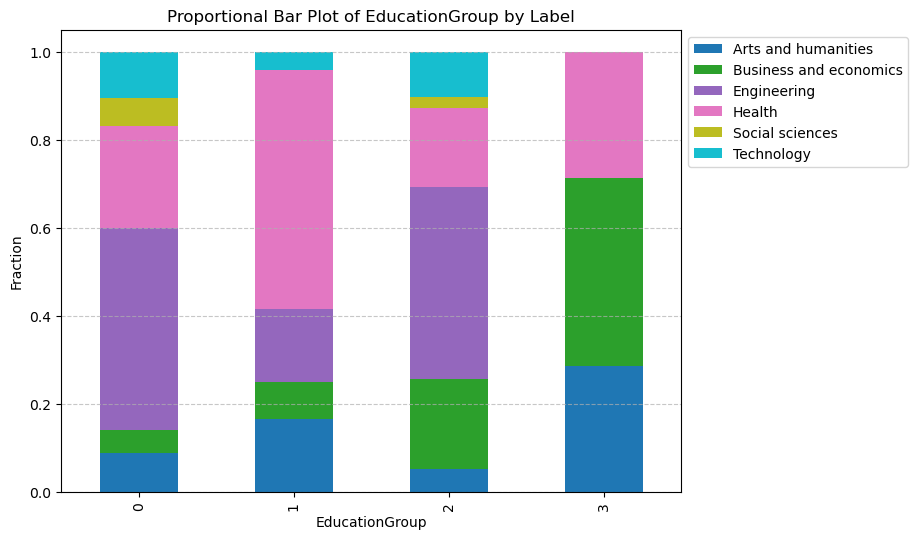

In [284]:
plot_ratio(edu_group_pivot.transpose(), edu_group_feature)

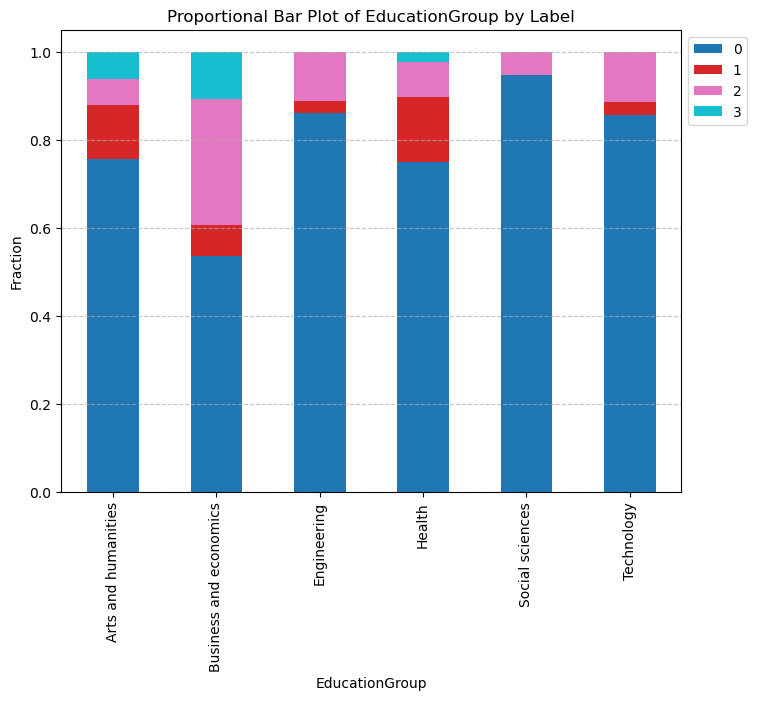

In [285]:
plot_ratio(edu_group_pivot, edu_group_feature)

In [286]:
chi_square_posthoc(edu_group_pivot.transpose())

no_of_comparisons:  15.0
Overall Chi-Square: 47.51, df: 15, p-value: 3.049232163817502e-05
0 vs 3: Chi-Square = 23.04, p = 0.0003312032279982824


### MaleParentEducationGroup

In [287]:
male_edu_group_feature = 'MaleParentEducationGroup'
male_edu_group_pivot = get_pivot(df, male_edu_group_feature)

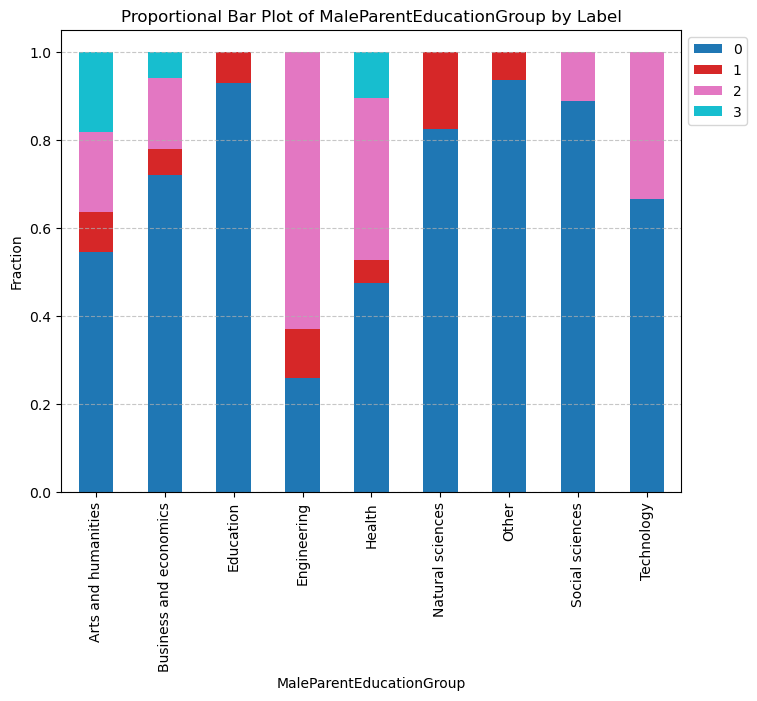

In [288]:
plot_ratio(male_edu_group_pivot, male_edu_group_feature)

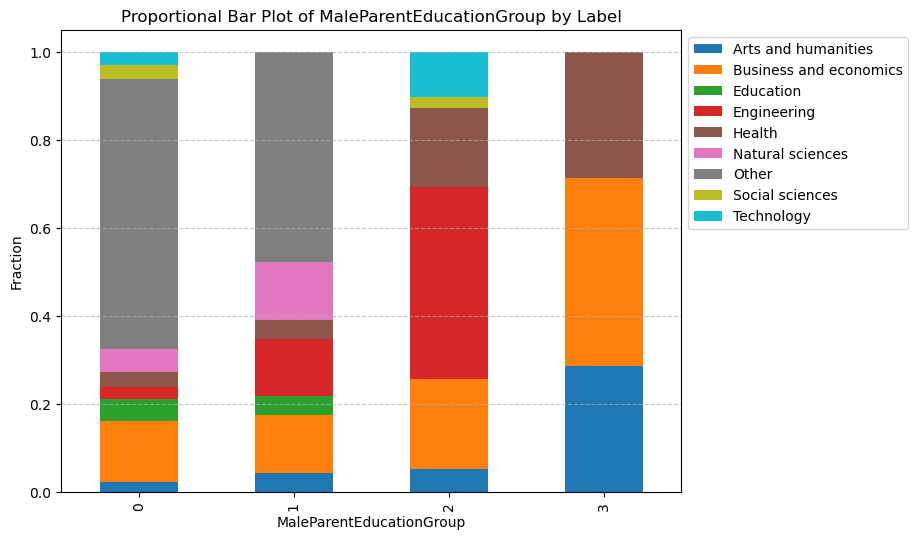

In [289]:
plot_ratio(male_edu_group_pivot.transpose(), male_edu_group_feature)

In [290]:
chi_square_posthoc(male_edu_group_pivot.transpose())

no_of_comparisons:  36.0
Overall Chi-Square: 151.73, df: 24, p-value: 1.580666175645784e-20
0 vs 2: Chi-Square = 118.77, p = 5.941928254818204e-22
0 vs 3: Chi-Square = 35.84, p = 1.881554493358992e-05
1 vs 2: Chi-Square = 35.12, p = 2.547227455447825e-05


### FemaleParentEducationGroup

In [291]:
female_edu_group_feature = 'FemaleParentEducationGroup'
female_edu_group_pivot = get_pivot(df, female_edu_group_feature)

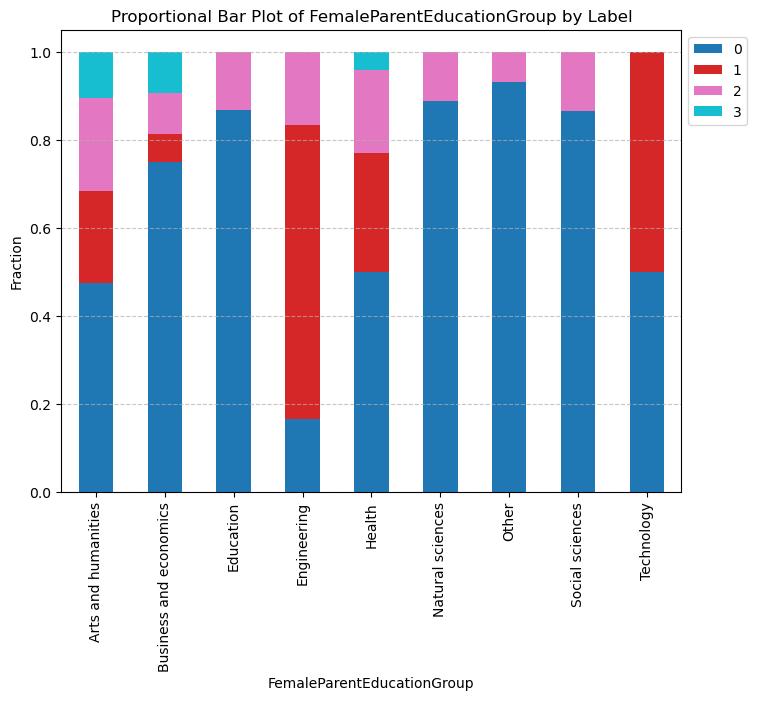

In [292]:
plot_ratio(female_edu_group_pivot, female_edu_group_feature)

In [293]:
chi_square_posthoc(female_edu_group_pivot.transpose())

no_of_comparisons:  36.0
Overall Chi-Square: 132.99, df: 24, p-value: 4.456636626684286e-17
0 vs 1: Chi-Square = 107.50, p = 1.2440741694886819e-19
0 vs 3: Chi-Square = 28.82, p = 0.00034035576742004974


### MaleParentEducationLevel

In [294]:
male_edu_level_feature = 'MaleParentEducationLevel'
male_edu_level_pivot = get_pivot(df, male_edu_level_feature)

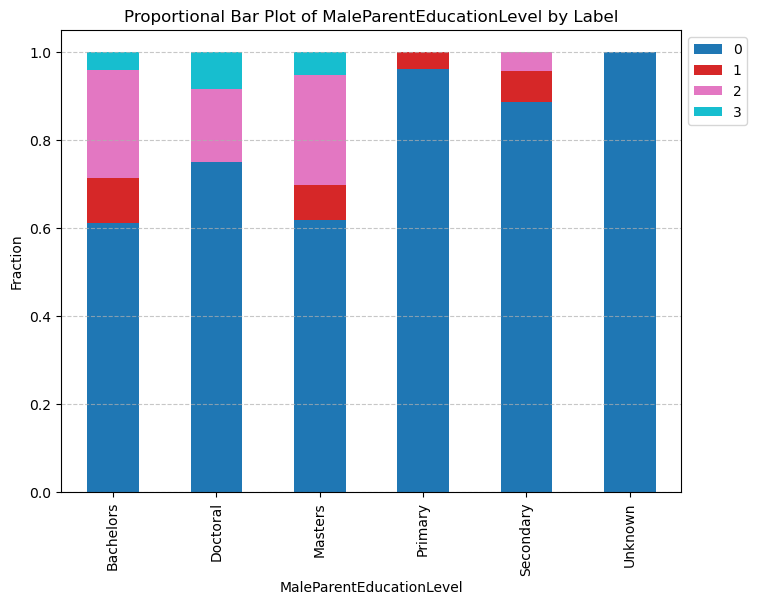

In [295]:
plot_ratio(male_edu_level_pivot, male_edu_level_feature)

In [296]:
chi_square_posthoc(male_edu_level_pivot.transpose())

no_of_comparisons:  15.0
Overall Chi-Square: 52.57, df: 15, p-value: 4.54991826843813e-06
0 vs 2: Chi-Square = 39.49, p = 1.889115786294819e-07


### FemaleParentEducationLevel

In [297]:
female_edu_level_feature = 'FemaleParentEducationLevel'
female_edu_level_pivot = get_pivot(df, female_edu_level_feature)

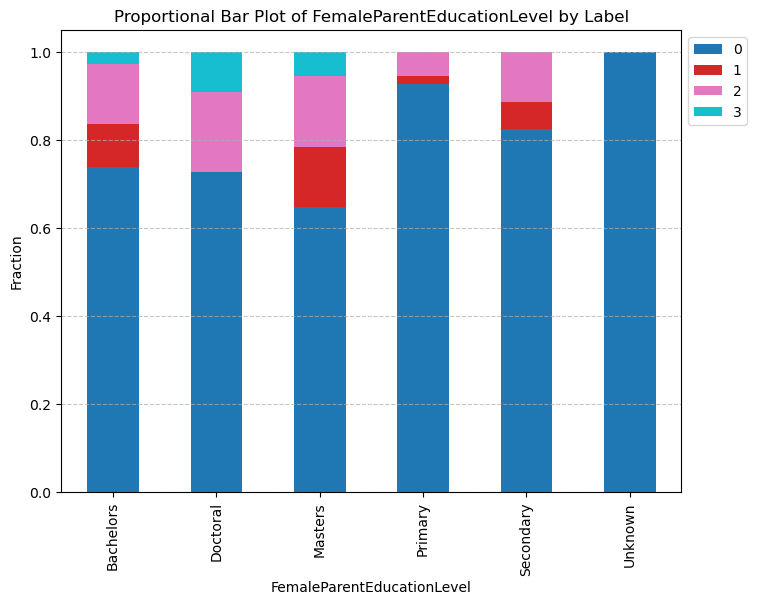

In [298]:
plot_ratio(female_edu_level_pivot, female_edu_level_feature)

In [299]:
chi_square_posthoc(female_edu_level_pivot.transpose())

no_of_comparisons:  15.0
Overall Chi-Square: 33.21, df: 15, p-value: 0.0043865051037044155


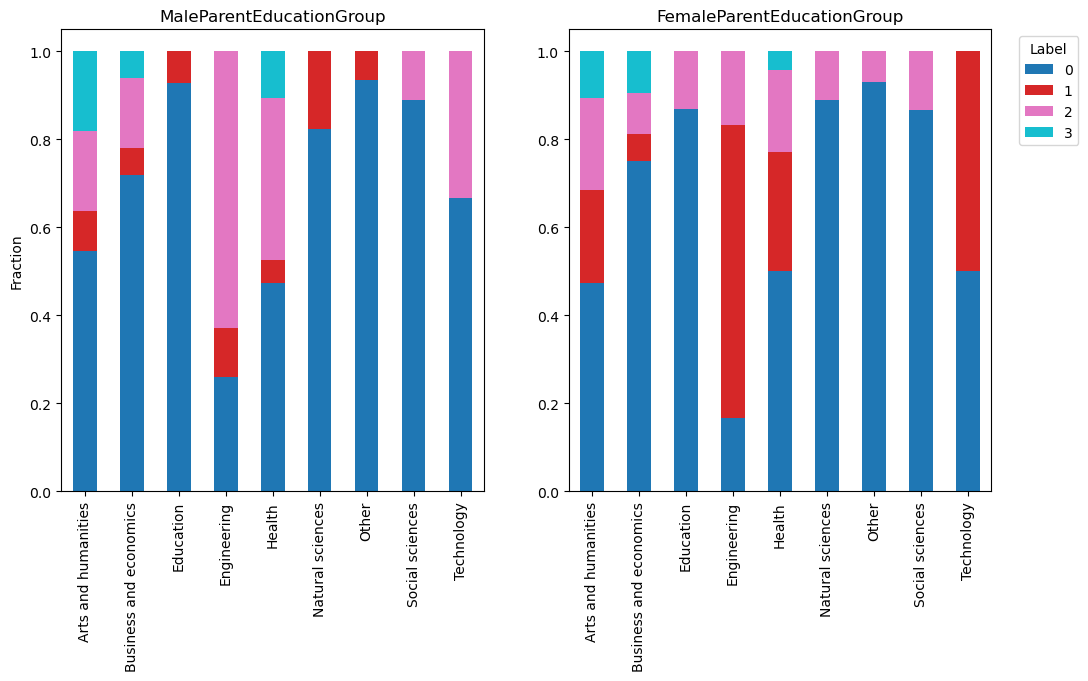

In [300]:
# Normalize by column sum so each column sums to 1
male_edu_group_ratio = male_edu_group_pivot.div(male_edu_group_pivot.sum(axis=0), axis=1).fillna(0)
female_edu_group_ratio = female_edu_group_pivot.div(female_edu_group_pivot.sum(axis=0), axis=1).fillna(0)
male_edu_level_ratio = male_edu_level_pivot.div(male_edu_level_pivot.sum(axis=0), axis=1).fillna(0)
female_edu_level_ratio = female_edu_level_pivot.div(female_edu_level_pivot.sum(axis=0), axis=1).fillna(0)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

male_edu_group_ratio.transpose().plot(ax=axes[0], kind='bar', stacked=True, colormap='tab10', title=male_edu_group_feature, legend=False)
female_edu_group_ratio.transpose().plot(ax=axes[1], kind='bar', stacked=True, colormap='tab10', title=female_edu_group_feature, legend=False)

plt.subplots_adjust(hspace=0.6)
handles, labels = axes[0].get_legend_handles_labels()
axes[1].legend(title="Label", loc='upper left', bbox_to_anchor=(1.05, 1))
axes[0].set_ylabel("Fraction")
plt.show()

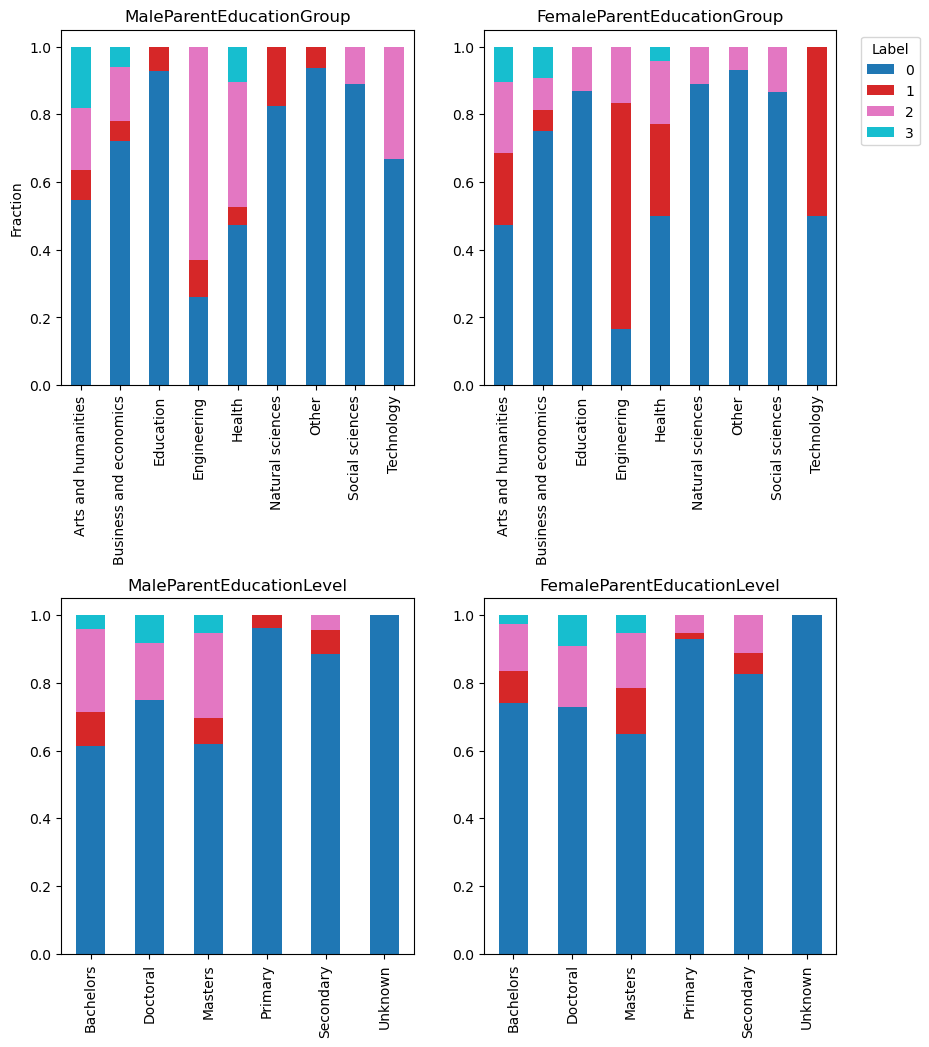

In [301]:
# Normalize by column sum so each column sums to 1
male_edu_group_ratio = male_edu_group_pivot.div(male_edu_group_pivot.sum(axis=0), axis=1).fillna(0)
female_edu_group_ratio = female_edu_group_pivot.div(female_edu_group_pivot.sum(axis=0), axis=1).fillna(0)
male_edu_level_ratio = male_edu_level_pivot.div(male_edu_level_pivot.sum(axis=0), axis=1).fillna(0)
female_edu_level_ratio = female_edu_level_pivot.div(female_edu_level_pivot.sum(axis=0), axis=1).fillna(0)

fig, axes = plt.subplots(2, 2, figsize=(10, 12))

male_edu_group_ratio.transpose().plot(ax=axes[0, 0], kind='bar', stacked=True, colormap='tab10', title=male_edu_group_feature, legend=False)
female_edu_group_ratio.transpose().plot(ax=axes[0, 1], kind='bar', stacked=True, colormap='tab10', title=female_edu_group_feature, legend=False)
male_edu_level_ratio.transpose().plot(ax=axes[1, 0], kind='bar', stacked=True, colormap='tab10', title=male_edu_level_feature, legend=False)
female_edu_level_ratio.transpose().plot(ax=axes[1, 1], kind='bar', stacked=True, colormap='tab10', title=female_edu_level_feature, legend=False)

plt.subplots_adjust(hspace=0.6)
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 1].legend(title="Label", loc='upper left', bbox_to_anchor=(1.05, 1))
axes[0, 0].set_ylabel("Fraction")

# Show plot
plt.show()

### Post-hoc Visualizations by gender

In [302]:
w_male_group_feature = 'MaleParentEducationGroup'
w_male_group_pivot = get_pivot(df[df['Gender']=="Woman"], w_male_group_feature)

m_male_group_feature = 'MaleParentEducationGroup'
m_male_group_pivot = get_pivot(df[df['Gender']=="Man"], m_male_group_feature)

w_female_group_feature = 'FemaleParentEducationGroup'
w_female_group_pivot = get_pivot(df[df['Gender']=="Woman"], w_female_group_feature)

m_female_group_feature = 'FemaleParentEducationGroup'
m_female_group_pivot = get_pivot(df[df['Gender']=="Man"], m_female_group_feature)

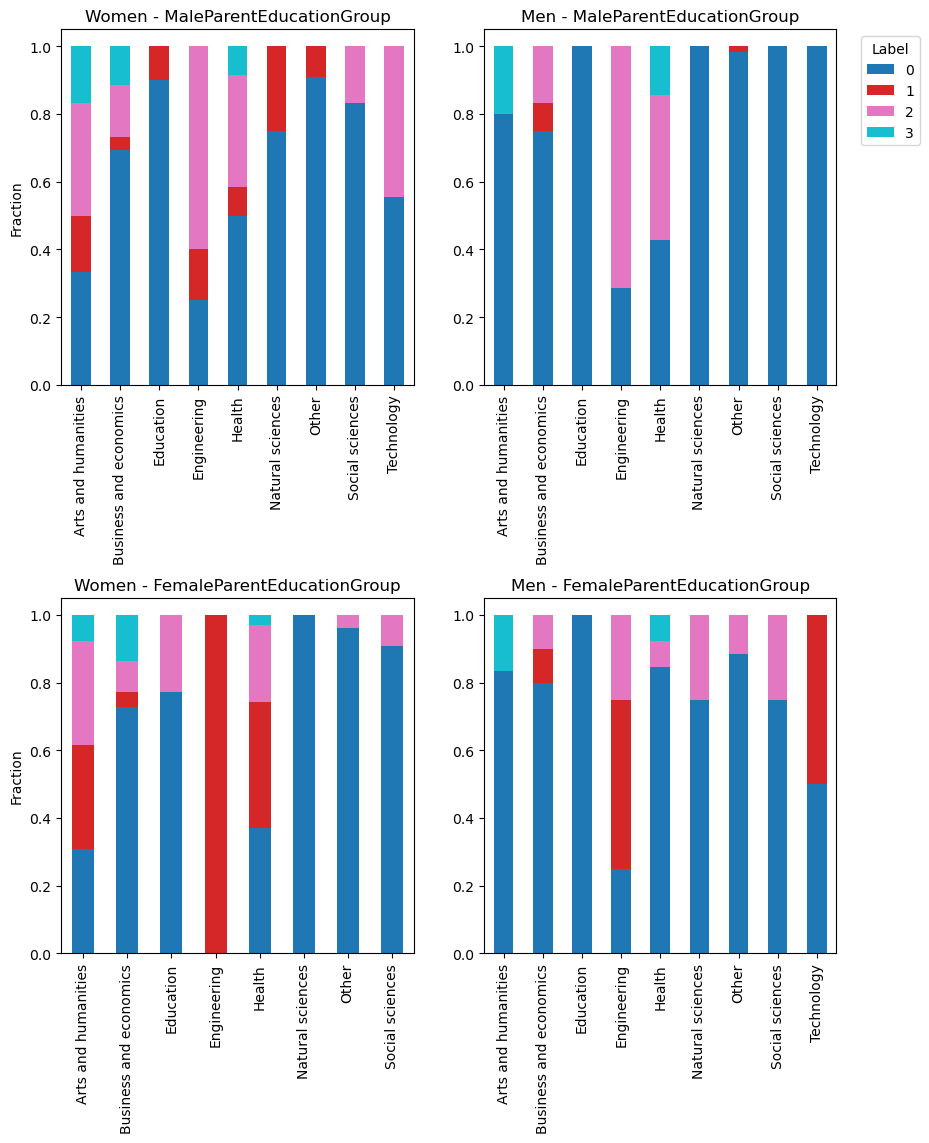

In [303]:
# Normalize by column sum so each column sums to 1
w_male_group_ratio = w_male_group_pivot.div(w_male_group_pivot.sum(axis=0), axis=1).fillna(0)
m_male_group_ratio = m_male_group_pivot.div(m_male_group_pivot.sum(axis=0), axis=1).fillna(0)
w_female_group_ratio = w_female_group_pivot.div(w_female_group_pivot.sum(axis=0), axis=1).fillna(0)
m_female_group_ratio = m_female_group_pivot.div(m_female_group_pivot.sum(axis=0), axis=1).fillna(0)

fig, axes = plt.subplots(2, 2, figsize=(10, 12))

w_male_group_ratio.transpose().plot(ax=axes[0,0], kind='bar', stacked=True, colormap='tab10', title=f"Women - {w_male_group_feature}", legend=False)
m_male_group_ratio.transpose().plot(ax=axes[0,1], kind='bar', stacked=True, colormap='tab10', title=f"Men - {m_male_group_feature}", legend=False)
w_female_group_ratio.transpose().plot(ax=axes[1,0], kind='bar', stacked=True, colormap='tab10', title=f"Women - {w_female_group_feature}", legend=False)
m_female_group_ratio.transpose().plot(ax=axes[1,1], kind='bar', stacked=True, colormap='tab10', title=f"Men - {m_female_group_feature}", legend=False)

plt.subplots_adjust(hspace=0.6)
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 1].legend(title="Label", loc='upper left', bbox_to_anchor=(1.05, 1))
axes[0, 0].set_ylabel("Fraction")
axes[1, 0].set_ylabel("Fraction")
plt.show()